In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import path
%matplotlib inline

In [2]:
path.insert(0, '../src')
from setup import data_setup
from data_generator import DataGenerator
from model_trainer import ModelTrainer

In [3]:
dg = data_setup()
norm_data = dg.df()

In [4]:
from data_transformation import get_isotope_data
isotope_data = get_isotope_data()

In [18]:
from data_transformation import get_suspicious_peaks, get_ranges, get_peak_suspiciousness
original_data = dg.calibrated_df(True, .005, .01,use_ranges=True, ranges=[0.25, 0.5, 0.75], cat=True)
ranges = get_ranges(isotope_data, 2000)
original_data['target'] = original_data['target'].apply(lambda a: a - 1 if a > 0 else a)
original_data['sus_peaks'] = original_data['masses'].apply(get_suspicious_peaks, args=(ranges, .1))
original_data['peak_sussness'] = original_data['masses'].apply(get_peak_suspiciousness, args=(ranges, True))

In [28]:
original_data['num_sus_peaks'] = original_data['sus_peaks'].apply(len)
original_data[original_data['target'] == 1].describe()

,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,target,err_prop_slope,err_prop_offset,num_sus_peaks,susness
count,433.000000,433.000000,433.000000,433.000000,433.0,433.000000,433.000000,433.000000,433.000000
mean,0.322896,-0.230184,2.845095,1.145092,1.0,0.000193,0.000079,158.792148,0.200009
std,0.092866,0.300712,4.924654,2.186295,0.0,0.002869,0.002106,149.032228,0.071486
min,0.169103,-1.183342,0.000000,0.138000,1.0,-0.004999,-0.004955,0.000000,-0.030743
25%,0.172823,-0.512984,0.000000,0.138000,1.0,-0.002355,0.000000,49.000000,0.176124
50%,0.378008,-0.000189,0.000000,0.138000,1.0,0.000289,0.000000,114.000000,0.227709
75%,0.380277,-0.000015,5.626000,1.250000,1.0,0.002746,0.000334,221.000000,0.243924
max,0.466051,0.000638,21.352000,20.000000,1.0,0.004967,0.004976,915.000000,0.308494


In [27]:
original_data[original_data['target'] == 0].describe()

,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,target,err_prop_slope,err_prop_offset,num_sus_peaks,susness
count,473.000000,473.000000,473.000000,473.000000,473.0,473.0,473.000000,473.000000,473.000000
mean,0.314966,-0.234184,3.419463,1.278497,0.0,0.0,-0.000030,78.048626,0.068121
std,0.097313,0.285822,5.622221,2.610802,0.0,0.0,0.002076,129.138146,0.057606
min,0.168588,-1.193615,-0.929000,0.138000,0.0,0.0,-0.004936,0.000000,-0.026244
25%,0.172205,-0.511926,0.000000,0.138000,0.0,0.0,-0.000105,7.000000,0.026113
50%,0.378689,-0.000290,0.000000,0.138000,0.0,0.0,0.000000,29.000000,0.050224
75%,0.379341,-0.000020,7.137000,1.250000,0.0,0.0,0.000297,88.000000,0.098455
max,0.463311,0.001708,21.571000,20.000000,0.0,0.0,0.004862,1008.000000,0.269278


In [26]:
original_data['susness'] = original_data['peak_sussness'].apply(np.mean)

In [48]:
training_data = original_data[original_data['num_sus_peaks'] >= 15].copy()[['peak_sussness', 'num_sus_peaks', 'susness','target']]

In [43]:
def get_n_sussest(susses, n=20):
    a = sorted(susses, reverse=True)
    return susses[0:n]

In [49]:
X = np.vstack(training_data['peak_sussness'].apply(get_n_sussest, args=(15,)))
X = np.hstack([X, np.array(training_data[['num_sus_peaks', 'susness']]).reshape(X.shape[0], 2)])
y = np.array(training_data['target'])

In [50]:
from model_trainer import ModelTrainer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
models = [RandomForestClassifier, LGBMClassifier, XGBClassifier]
names = ['rfc', 'lgbm', 'xgb']
mt = ModelTrainer(models, X, y, names)

In [51]:
accs, indices_preds = mt.kfold_models(5, model_params=[{'n_estimators': 10}, {}, {}])
accs

[0.8774997393389636, 0.9092169742466896, 0.8977166093212388]

Text(0, 0.5, 'Accuracy')

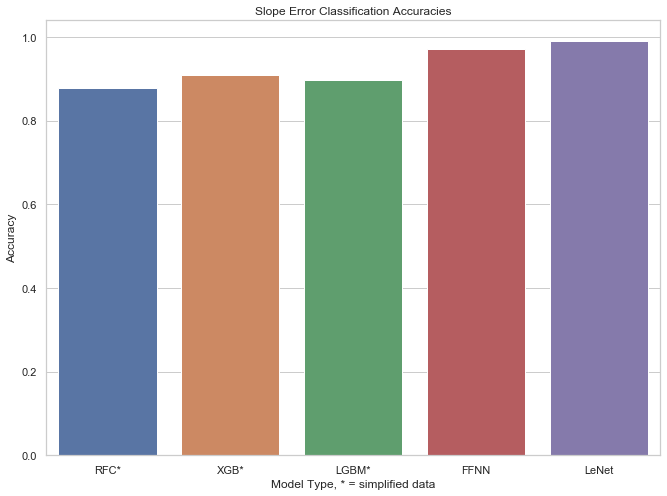

In [72]:
x = [0.8774997393389636, 0.9092169742466896, 0.8977166093212388, 0.97, 0.99]
names = ['RFC*', 'XGB*', 'LGBM*', 'FFNN', 'LeNet']
plt.figure(figsize=(11, 8))
sns.set(style='whitegrid')
sns.barplot(y=x, x=names)
plt.title('Slope Error Classification Accuracies')
plt.xlabel('Model Type, * = simplified data')
plt.ylabel('Accuracy')
